### Notes to recruiter

- This project took 3 hours to complete.
- It poses an interesting challenge, because the target variable (price_range) is categorical but can be laid out on a continuum (smaller price to bigger price).
- Since price_range is evenly distributed, the literature says we can use RMSE without much issue. If it was unevenly distributed, maybe a custom MSE would be needed.

### Load csv file and store in Pandas DataFrame

In [2]:
import pandas as pd

df = pd.read_csv('train.csv')

### Exploratory Data Analysis (EDA)

#### Plot distribution of all columns

With the distribution plot, we can see the frequency histogram of the features. We can visualize through this plot that some variables are categorical, and not continuous (dual_sim, four_g, three_g, touch_screen, wifi, price_range, n_cores). dual_sim, four_g, three_g, touch_screen and wifi, specifically, are nominal categorical variables. price_range and n_cores are ordinal categorical variables.

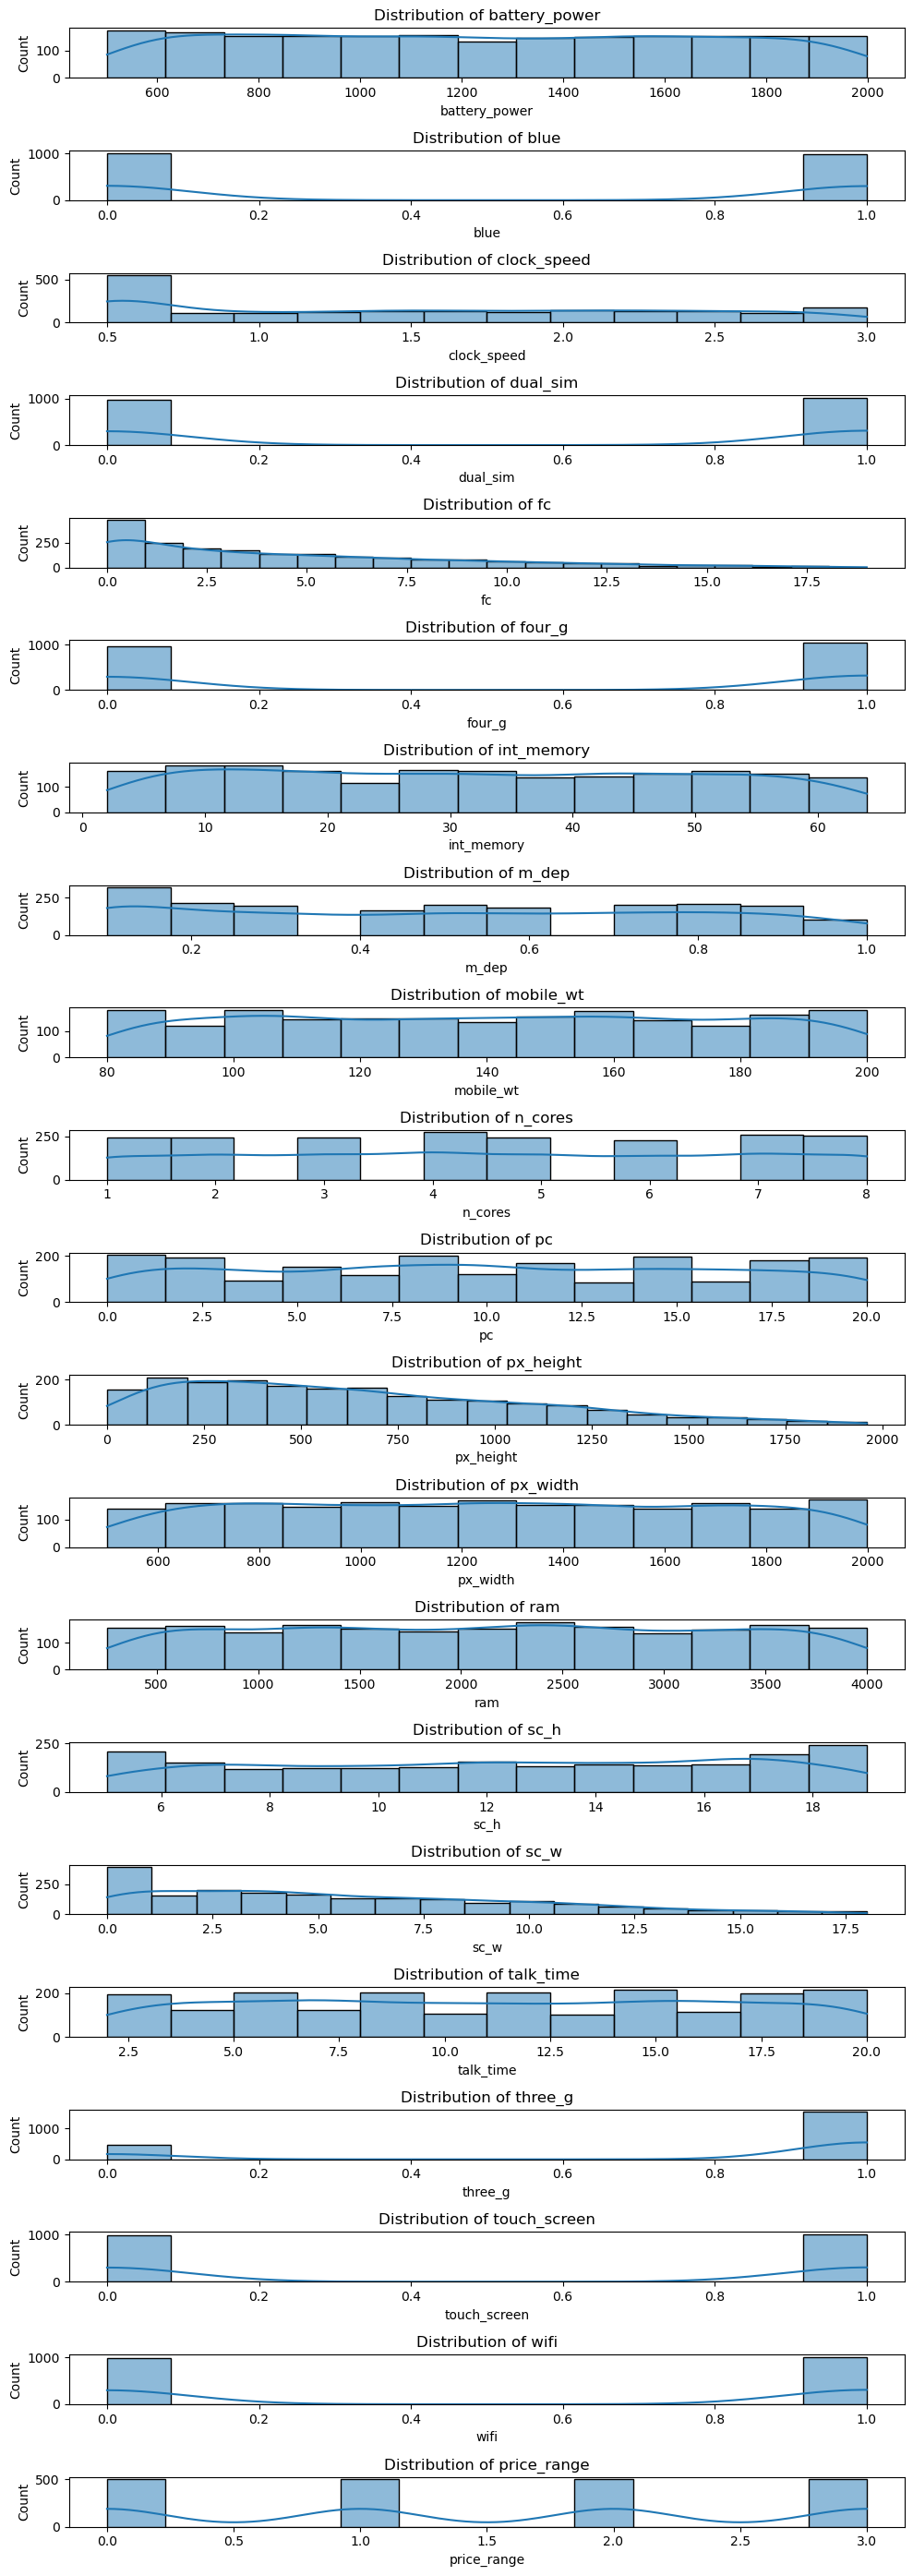

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = df.columns

fig, axes = plt.subplots(nrows=len(columns), figsize=(10, 28))

for i, column in enumerate(columns):
    sns.histplot(data=df, x=column, kde=True, ax=axes[i])

for i, column in enumerate(columns):
    axes[i].set_title(f"Distribution of {column}")
    axes[i].set_xlabel(column)

plt.tight_layout()

plt.show()

In [3]:
# Convert nomimal categorical variables to bool
df[['dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']] = df[['dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']].astype(int)
df.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

#### Feature engineering

We use **featuretools** to generate new features that are sum or multiplication of existing features. **PolynomialFeatures** is also used to generate the squared or cubed version of features.

In [4]:
import featuretools as ft

In [5]:
es = ft.EntitySet("price_range")
es = es.add_dataframe(
      dataframe_name="data",
      dataframe=df.drop(columns=["price_range"]),	
      index="index",
)

df_fts, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

df = pd.concat([df_fts, df["price_range"]], axis=1)

/opt/conda/lib/python3.11/site-packages/featuretools/entityset/entityset.py:1914: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/featuretools/synthesis/deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


In [6]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
df_poly = poly.fit_transform(df.drop(columns=['price_range']))
df_poly = pd.DataFrame(df_poly, columns=poly.get_feature_names_out(df.columns[:-1]))

df = pd.concat([df_poly, df['price_range']], axis=1)

#### Feature Selection

Features were selected based on **Pearson correlation**. Any feature with corr greater than > 0.9 and smaller than -0.9 was selected. These values were tuned bsed on error analysis.

A scatter plot is shown to represent the relation between the selected column and the target price_range.

In [7]:
correlation_matrix = df.corrwith(df['price_range'])
selected_features = correlation_matrix[(correlation_matrix > 0.9) | (correlation_matrix < -0.9)].index.drop('price_range')

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [80]:
selected_features

Index(['ram', 'battery_power + ram', 'blue + ram', 'clock_speed + ram',
       'dual_sim + ram', 'fc + ram', 'four_g + ram', 'int_memory + ram',
       'm_dep + ram', 'mobile_wt + ram', 'n_cores + ram', 'pc + ram',
       'px_height + ram', 'px_width + ram', 'ram + sc_h', 'ram + sc_w',
       'ram + talk_time', 'ram + three_g', 'ram + touch_screen', 'ram + wifi',
       'ram battery_power + px_width', 'ram battery_power + ram',
       'ram px_height + ram', 'ram px_width + ram',
       'battery_power + px_width blue + ram',
       'battery_power + px_width clock_speed + ram',
       'battery_power + px_width dual_sim + ram',
       'battery_power + px_width fc + ram',
       'battery_power + px_width four_g + ram',
       'battery_power + px_width int_memory + ram',
       'battery_power + px_width m_dep + ram',
       'battery_power + px_width mobile_wt + ram',
       'battery_power + px_width n_cores + ram',
       'battery_power + px_width pc + ram',
       'battery_power + px_width

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

num_columns = 9

num_rows = (len(selected_features) - 1) // num_columns + 1

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(80, 80))

axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.scatterplot(data=df, x=feature, y="price_range", ax=axes[i])
    axes[i].set_title(f"Scatterplot of {feature} vs price_range")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("price_range")

# Remove any empty subplots
if len(selected_features) < num_rows * num_columns:
    for j in range(len(selected_features), num_rows * num_columns):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('scatterplot.png')
plt.show()


### Models Trained

Three machine learning models were chosen, **Linear Regression (LR), XGBoost (XGB) and Feed-Forward Neural Network (FFNN)**. They represent a simple linear mapping between explanatory and response variables, an ensemble method of decision trees trained with Gradient Descent and Neural Network model.

Each technique is evaluated with Cross-Validation (CV) and given a **CV average error**. XGB and FFNN have an additional inner loop of CV to tune hyperparameters. Additionaly, a final model is trained for each technique and a **final error is given**.

The error metric chosen to evaluate on test set was **RMSE**. The problem was treated as a regression problem, and for that, RMSE is sufficient if target labels are balanced. Because we treated it as a regression problem, predicted values are continuous. When evaluating on test set, we round these predictions (rounded_error), as to give an ordinal feature (1,2 or 3). 

A plot of training loss and validation loss is provided for XGB and FFNN.
- Average CV errors:
  - XGB : 0.2538
  - FFNN: 0.3275
  - LR  : 0.3527

The best overall method for this task was **XGB**, followed by FFNN and Linear Regression.

In [54]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import make_scorer
from matplotlib import pyplot as plt

X = df[selected_features]
y = df['price_range']

def rounded_error(y_true, y_pred, **kwargs):
    y_pred_rounded = np.round(y_pred)
    error = mean_squared_error(y_true,y_pred_rounded, squared=False)
    return error

rounded_error_scorer = make_scorer(rounded_error, greater_is_better=False)

#### Linear Regression

In [56]:
from sklearn.linear_model import LinearRegression

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Apply MinMaxScaler
    ('model', LinearRegression())  # Apply LinearRegression
])

nested_score = cross_val_score(pipeline, X=X, y=y, cv=outer_cv, scoring=rounded_error_scorer)

In [62]:
print(f"The RMSE error for each outer split is: {nested_score*-1}")
print(f"The average is: {nested_score.mean()*-1}")

The RMSE error for each outer split is: [0.36400549 0.35       0.34278273 0.36742346 0.3391165 ]
The average is: 0.3526656370115636


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [60]:
rmse = rounded_error(y_test, pipeline.predict(X_test))
print(f"Final LR RMSE error is {rmse}")

Final LR RMSE error is 0.36055512754639896


#### XGBoost

In [75]:
import xgboost as xgb

inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'model__max_depth': [10, 32, 64],
    'model__learning_rate': [0.1],
    'model__n_estimators': [1, 32, 64],
}


# Create the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Apply MinMaxScaler
    ('model', xgb.XGBRegressor())  # Apply LinearRegression
])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=inner_cv, scoring=rounded_error_scorer)
nested_score = cross_val_score(grid_search, X=X, y=y, cv=outer_cv, scoring=rounded_error_scorer)

In [76]:
print(f"The RMSE error for each outer split is: {nested_score*-1}")
print(f"The average is: {nested_score.mean()*-1}")

The RMSE error for each outer split is: [0.24494897 0.25980762 0.25495098 0.23979158 0.26925824]
The average is: 0.25375147752313


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=outer_cv, scoring=rounded_error_scorer)
grid_search.fit(pd.concat([X_train,X_val]), pd.concat([y_train,y_val])) 
best_params = {k.replace('model__', ''): v for k, v in grid_search.best_params_.items() if k.startswith('model__')}

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', xgb.XGBRegressor(**best_params)) 
])

pipeline_scaler = Pipeline(pipeline.steps[:-1])
X_train_transformed = pipeline_scaler.fit_transform(X_train)
X_val_transformed = pipeline_scaler.transform(X_val)
X_test_transformed = pipeline_scaler.transform(X_test)

model = pipeline.steps[-1][1]
model.fit(X_train_transformed, y_train, eval_set=[(X_train_transformed, y_train), (X_val_transformed, y_val)], verbose=False, early_stopping_rounds=5)

/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=32, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=32, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [78]:
rmse = rounded_error(y_test, model.predict(X_test_transformed))
print(f"Final XGB RMSE error is {rmse}")
print(best_params)

Final XGB RMSE error is 0.229128784747792
{'learning_rate': 0.1, 'max_depth': 32, 'n_estimators': 32}


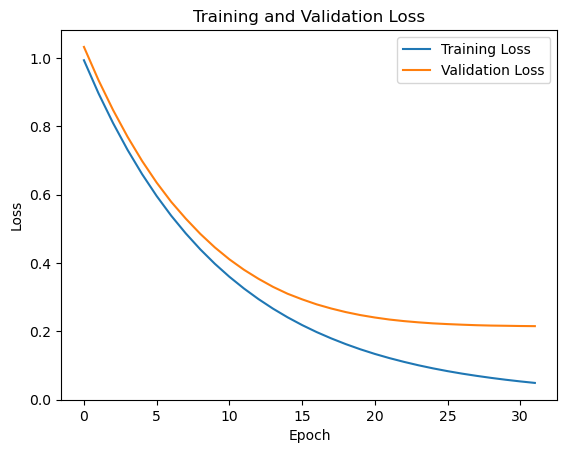

In [79]:
import matplotlib.pyplot as plt

# Train the XGBoost regressor model
model.fit(X_train, y_train)

# Get the training and validation loss history
train_loss = model.evals_result()['validation_0']['rmse']
val_loss = model.evals_result()['validation_1']['rmse']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


#### FFNN

In [70]:
from tensorflow import keras
from scikeras.wrappers import KerasRegressor

inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'model__learning_rate': [0.01, 0.001],
    'model__neurons_1': [1, 32, 64, 128],
    'model__neurons_2': [1, 32, 64, 128]
}

def create_model(neurons_1=1, neurons_2=1, learning_rate=0.01):
    model = keras.Sequential([
        keras.layers.Dense(neurons_1, activation='relu', input_shape=(X.shape[1],)),
        keras.layers.Dense(neurons_2, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')
    return model

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('model', KerasRegressor(model=create_model, epochs=10, batch_size=32, verbose=0, neurons_1=1, neurons_2=1, learning_rate=0.01)) 
])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=inner_cv, scoring=rounded_error_scorer)
nested_score = cross_val_score(grid_search, X=X, y=y, cv=outer_cv, scoring=rounded_error_scorer)


In [71]:
print(f"The RMSE error for each outer split is: {nested_score*-1}")
print(f"The average is: {nested_score.mean()*-1}")

The RMSE error for each outer split is: [0.4472136  0.27386128 0.27838822 0.36400549 0.27386128]
The average is: 0.3274659731221302


In [72]:
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=outer_cv, scoring=rounded_error_scorer)
grid_search.fit(pd.concat([X_train,X_val]), pd.concat([y_train,y_val])) 
best_params = {k.replace('model__', ''): v for k, v in grid_search.best_params_.items() if k.startswith('model__')}

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', KerasRegressor(model=create_model, epochs=10, batch_size=32, verbose=0, **best_params)) 
])

pipeline_scaler = Pipeline(pipeline.steps[:-1])
X_train_transformed = pipeline_scaler.fit_transform(X_train)
X_val_transformed = pipeline_scaler.transform(X_val)
X_test_transformed = pipeline_scaler.transform(X_test)

model = pipeline.steps[-1][1]
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model.fit(X_train_transformed, y_train, validation_data=(X_val_transformed, y_val), callbacks=[early_stopping])

KerasRegressor(
	model=<function create_model at 0x7fd90b1da160>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	learning_rate=0.01
	neurons_1=64
	neurons_2=128
)

In [73]:
rmse = rounded_error(y_test, model.predict(X_test_transformed))
print(f"Final FFNN RMSE error is {rmse}")
print(best_params)

Final FFNN RMSE error is 0.3427827300200522
{'learning_rate': 0.01, 'neurons_1': 64, 'neurons_2': 128}


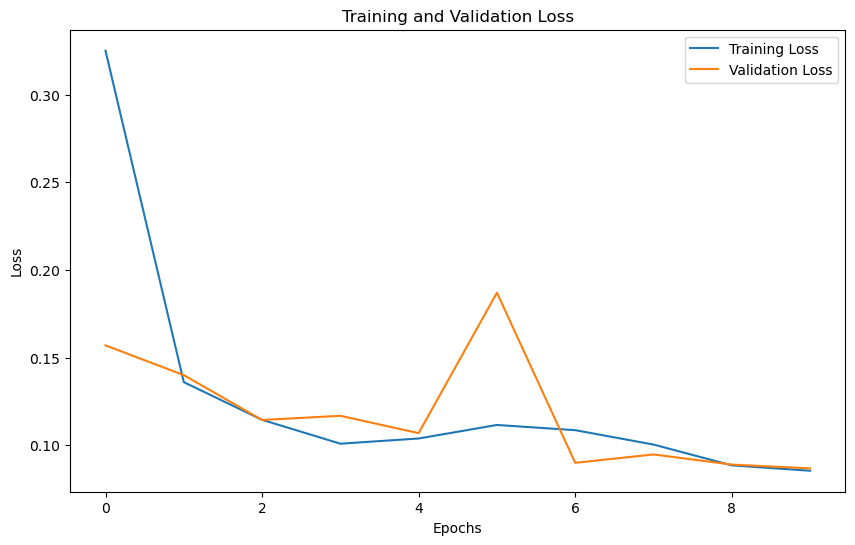

In [74]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(model.history_['loss'], label='Training Loss')
plt.plot(model.history_['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()